In [1]:
import sys
sys.path.append("../")

from covid_loader.covid_loader import *
from covid_loader.collate_funcs import *

## Create a CovidDataset

In [2]:
%%time
ds_train = USCasesDataset(root = "../data", download = True,
                          Province_State= ["California", "New York"],
                          remove_negative_days = True, # remove "early" days of pandemic 
                          date_range=(None, pd.to_datetime("2020-08-01")))


ds_valid = USCasesDataset(root = "../data", download = False, 
                          Province_State= ["California", "New York"], 
                          remove_negative_days = True,
                          date_range=(pd.to_datetime("2020-08-02"), 
                                      pd.to_datetime("2020-08-15")))


ds_test = USCasesDataset(root = "../data", download = False, 
                         Province_State= ["California", "New York"], 
                         remove_negative_days = True,
                         date_range=(pd.to_datetime("2020-08-16"),
                                     None))


CPU times: user 20.3 s, sys: 1.16 s, total: 21.4 s
Wall time: 22.6 s


In [3]:
len(ds_train), len(ds_valid), len(ds_test)

(124, 124, 124)

## Create DataLoader

In [4]:
from torch.utils.data import DataLoader

In [5]:
tr_loader = list(DataLoader(ds_train, num_workers=0, batch_size = 1,
                            collate_fn=features_collate))

vl_loader = list(DataLoader(ds_valid, num_workers=0, batch_size = 1,
                            collate_fn=features_collate))

ts_loader = list(DataLoader(ds_test, num_workers=0, batch_size = 1,
                            collate_fn=features_collate))

/anaconda3/envs/covid-torch/lib/python3.8/site-packages/torch/tensor.py:721: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629449223/work/c10/core/TensorImpl.h:840.)
  return super(Tensor, self).rename_(names)


## Create DataLoader with windowed features

In [6]:
tr_loader = list(DataLoader(ds_train, num_workers=0, batch_size = 1,
                            collate_fn=windowed_features_collate))


## Train a baseline model

In [7]:
tr_loader = DataLoader(ds_train, num_workers=0, batch_size = 1,
                            collate_fn=features_collate)

vl_loader = DataLoader(ds_valid, num_workers=0, batch_size = 1,
                            collate_fn=features_collate)

ts_loader = DataLoader(ds_test, num_workers=0, batch_size = 1,
                            collate_fn=features_collate)

In [8]:
from networks import Ridge

In [9]:
losses = {}
for tr_batch, vl_batch, ts_batch in zip(tr_loader, vl_loader, ts_loader):
    if tr_batch[1][0].shape[0] < 5:
        continue
    X_tr, y_tr = tr_batch.features, tr_batch.targets
    X_vl, y_vl = vl_batch.features, vl_batch.targets
    X_ts, y_ts = ts_batch.features, ts_batch.targets

    model = Ridge(alpha = 1e-3)
    model.fit(X_tr.squeeze(), y_tr)
  

    tr_loss = torch.nn.functional.l1_loss(model.predict(X_tr.squeeze()), 
                                          y_tr.rename(None).view(-1,1)).item()
    vl_loss = torch.nn.functional.l1_loss(model.predict(X_vl.squeeze()), 
                                          y_vl.rename(None).view(-1,1)).item()
    ts_loss = torch.nn.functional.l1_loss(model.predict(X_ts.squeeze()), 
                                          y_ts.rename(None).view(-1,1)).item()
    losses[tr_batch[0][0]] = [tr_loss, vl_loss, ts_loss]
 

# Visualize Results

In [10]:
df_losses = pd.DataFrame.from_dict(losses, orient = "index", 
                                   columns = ["train", "valid", "test"])

In [11]:
import matplotlib.pyplot as plt

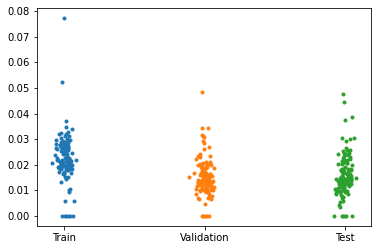

In [12]:
plt.plot(np.ones(df_losses.shape[0]) + .03*np.random.randn(df_losses.shape[0]), 
         df_losses.iloc[:,0], '.')
plt.plot(2*np.ones(df_losses.shape[0]) + .03*np.random.randn(df_losses.shape[0]), 
         df_losses.iloc[:,1], '.')
plt.plot(3*np.ones(df_losses.shape[0]) + .03*np.random.randn(df_losses.shape[0]), 
         df_losses.iloc[:,2], '.')

plt.xticks([1,2,3], ["Train", "Validation", "Test"]);